In [2]:
import gudhi
import numpy as np
import pandas as pd
from pds_functions import *
from kde_functions import *
from DTM_filtrations import *
import matplotlib.pyplot as plt

#### Load the data matrices

In [4]:
planet = pd.read_csv('../data/application/tde_planet.csv')
n_samples_planet = planet.shape[0]
print(planet.head())

planetspot1 = pd.read_csv('../data/application/tde_planetspot1.csv')
n_samples_planetspot1 = planetspot1.shape[0]
print(planetspot1.head())

planetspot2 = pd.read_csv('../data/application/tde_planetspot2.csv')
n_samples_planetspot2 = planetspot2.shape[0]
print(planetspot2.head())

spot = pd.read_csv('../data/application/tde_spot.csv')
n_samples_spot = spot.shape[0]
print(spot.head())

planet = np.asarray(planet)
planetspot1 = np.asarray(planetspot1)
planetspot2 = np.asarray(planetspot2)
spot = np.asarray(spot)

        PC1       PC2
0  0.996588 -0.082540
1  0.882544 -0.470230
2  0.607290 -0.794481
3  0.205901 -0.978573
4 -0.241295 -0.970452
        PC1       PC2
0  0.436066  0.726767
1  0.597591  0.460942
2  0.717953  0.053915
3  0.659165 -0.464859
4  0.649831 -0.578113
        PC1       PC2
0  0.545106 -0.770803
1  0.563853 -0.563912
2  0.920447 -0.196128
3  0.707354  0.271551
4  0.821063  0.442663
        PC1       PC2
0 -0.770555  0.585189
1 -0.827701  0.531861
2 -0.876557  0.467597
3 -0.919125  0.387206
4 -0.958965  0.280425


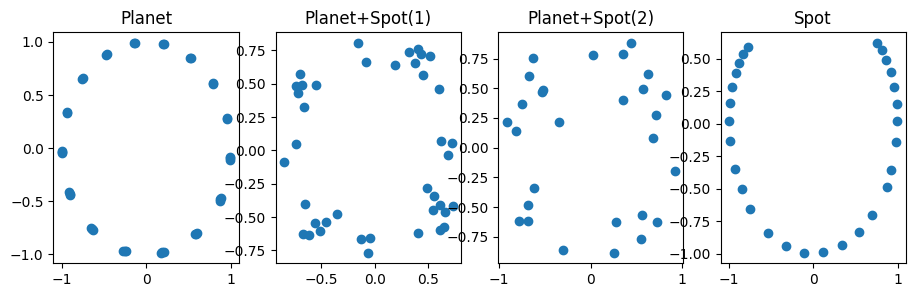

In [5]:
# This is just plotting the first two dimensions
fig, axs = plt.subplots(1, 4, figsize=(11, 3))
axs[0].scatter(x=planet[:, 0], y=planet[:, 1])
axs[0].set_title('Planet')
axs[1].scatter(x=planetspot1[:, 0], y=planetspot1[:, 1])
axs[1].set_title('Planet+Spot(1)')
axs[2].scatter(x=planetspot2[:, 0], y=planetspot2[:, 1])
axs[2].set_title('Planet+Spot(2)')
axs[3].scatter(x=spot[:, 0], y=spot[:, 1])
axs[3].set_title('Spot')
plt.show()

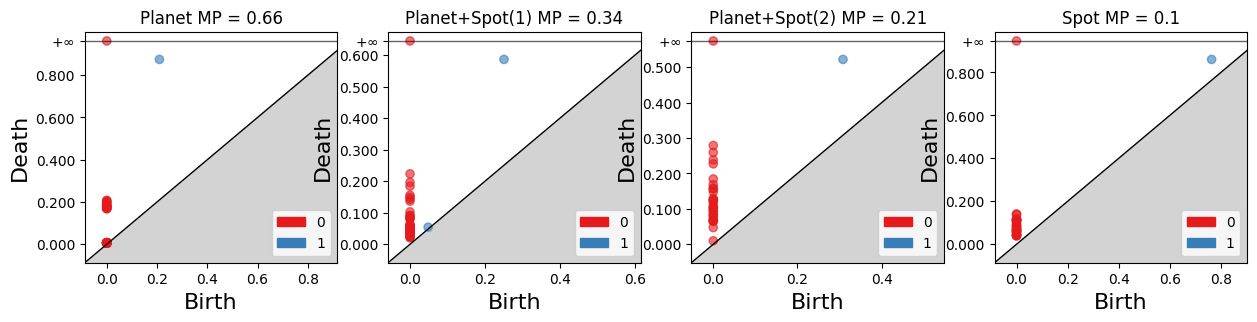

In [8]:
m = 0.001
diagram_DTM_planet, _, _ = dtm_diagram(planet, m)
diagram_DTM_planetspot1, _, _ = dtm_diagram(planetspot1, m)
diagram_DTM_planetspot2, _, _ = dtm_diagram(planetspot2, m)
diagram_DTM_spot, _, _ = dtm_diagram(spot, m)

# Compute the DTM persistence diagrams
def max_pers(diagram):
    filtered_items = [item for item in diagram if item[0] == 1]
    if not filtered_items:
        max_pers = 0
    else:
        differences = [pair[1][1] - pair[1][0] for pair in filtered_items]
        max_pers = max(differences)
    return max_pers

max_pers_planet = max_pers(diagram_DTM_planet)
max_pers_planetspot1 = max_pers(diagram_DTM_planetspot1)
max_pers_planetspot2 = max_pers(diagram_DTM_planetspot2)
max_pers_spot = max_pers(diagram_DTM_spot)

fig, axes = plt.subplots(1, 4, figsize=(15, 3))
gudhi.plot_persistence_diagram(diagram_DTM_planet, axes=axes[0])
axes[0].set_title(f'Planet MP = {np.round(max_pers_planet, 2)}')
gudhi.plot_persistence_diagram(diagram_DTM_planetspot1, axes=axes[1])
axes[1].set_title(f'Planet+Spot(1) MP = {np.round(max_pers_planetspot1, 2)}')
gudhi.plot_persistence_diagram(diagram_DTM_planetspot2, axes=axes[2])
axes[2].set_title(f'Planet+Spot(2) MP = {np.round(max_pers_planetspot2, 2)}')
gudhi.plot_persistence_diagram(diagram_DTM_spot, axes=axes[3])
axes[3].set_title(f'Spot MP = {np.round(max_pers_spot, 2)}')
plt.show()

### Search for the optimal thresholding parameter

In [13]:
# For the Planet+Spot with Planet Parameters
np.random.seed(160)
thresholds = np.linspace(0, 1, 10001)
kks = np.linspace(1, 1, 1, dtype=int) # the number of nearest neighbors
curr = 0; prev = 0; 
max1_th_pers = []
for kk in kks:
    # Fit the kde and extract the minimum density
    _, props, _ = kde_fit(planetspot1, k=kk, eps=0)
    min_dens = props[2]
    # Now use this min density to loop over the thresholds
    for th in thresholds:
        kde_fit_thresh_, props_thresh_, bounding_box_ = kde_fit(planetspot1, k=kk, eps=min_dens-th)
        kde_samples_thresh_, _= kde_sample(kde=kde_fit_thresh_, proposals=props_thresh_, bounding_box=bounding_box_, num_samples=n_samples_planetspot1)  
        dgm_dtm, _, _ = dtm_diagram(kde_samples_thresh_, m=0.001)
        curr = max_pers(dgm_dtm)
        if curr > prev:
            sampled_thresh1 = kde_samples_thresh_
            opt_th1 = th
            opt_kk1 = kk
            print(f'Max Pers = { np.round(curr, 2) } | Optimal Thrsh = {np.round(opt_th1, 4)} | NN (k) = {opt_kk1}')
            print('................................................................................')
            prev = curr
        max1_th_pers.append(curr)

Max Pers = 0.215 | Optimal Thrsh = 0.0 | NN (k) = 1
................................................................................
Max Pers = 0.2488 | Optimal Thrsh = 0.0001 | NN (k) = 1
................................................................................
Max Pers = 0.3311 | Optimal Thrsh = 0.0002 | NN (k) = 1
................................................................................
Max Pers = 0.3587 | Optimal Thrsh = 0.0003 | NN (k) = 1
................................................................................
Max Pers = 0.3715 | Optimal Thrsh = 0.0006 | NN (k) = 1
................................................................................
Max Pers = 0.3968 | Optimal Thrsh = 0.0036 | NN (k) = 1
................................................................................
Max Pers = 0.4456 | Optimal Thrsh = 0.134 | NN (k) = 1
................................................................................


In [14]:
# For the Planet+Spot with Spot Parameters
np.random.seed(160)
thresholds = np.linspace(0, 1, 10001)
kks = np.linspace(1, 1, 1, dtype=int)
curr = 0; prev = 0; 
max1_th_pers = []
for kk in kks:
    # Fit the kde and extract the minimum density
    _, props, _ = kde_fit(planetspot2, k=kk, eps=0)
    min_dens = props[2]
    # Now use this min density to loop over the thresholds
    for th in thresholds:
        kde_fit_thresh_, props_thresh_, bounding_box_ = kde_fit(planetspot2, k=kk, eps=min_dens-th)
        kde_samples_thresh_, _= kde_sample(kde=kde_fit_thresh_, proposals=props_thresh_, bounding_box=bounding_box_, num_samples=n_samples_planetspot2)  
        dgm_dtm, _, _ = dtm_diagram(kde_samples_thresh_, m=0.001)
        curr = max_pers(dgm_dtm)
        if curr > prev:
            sampled_thresh2 = kde_samples_thresh_
            opt_th2 = th 
            opt_kk2 = kk
            print(f'Max Pers = { np.round(curr, 2   ) } | Optimal Thrsh = {np.round(opt_th2, 4)} | NN (k) = {opt_kk2}')
            print('................................................................................')
            prev = curr
        max1_th_pers.append(curr)
    print(kk)

Max Pers = 0.17 | Optimal Thrsh = 0.0 | NN (k) = 1
................................................................................
Max Pers = 0.17 | Optimal Thrsh = 0.0002 | NN (k) = 1
................................................................................
Max Pers = 0.2 | Optimal Thrsh = 0.0014 | NN (k) = 1
................................................................................
Max Pers = 0.24 | Optimal Thrsh = 0.0015 | NN (k) = 1
................................................................................
Max Pers = 0.25 | Optimal Thrsh = 0.0019 | NN (k) = 1
................................................................................
Max Pers = 0.28 | Optimal Thrsh = 0.0023 | NN (k) = 1
................................................................................
Max Pers = 0.32 | Optimal Thrsh = 0.0122 | NN (k) = 1
................................................................................
Max Pers = 0.35 | Optimal Thrsh = 0.0223 | NN (k) = 1
.....

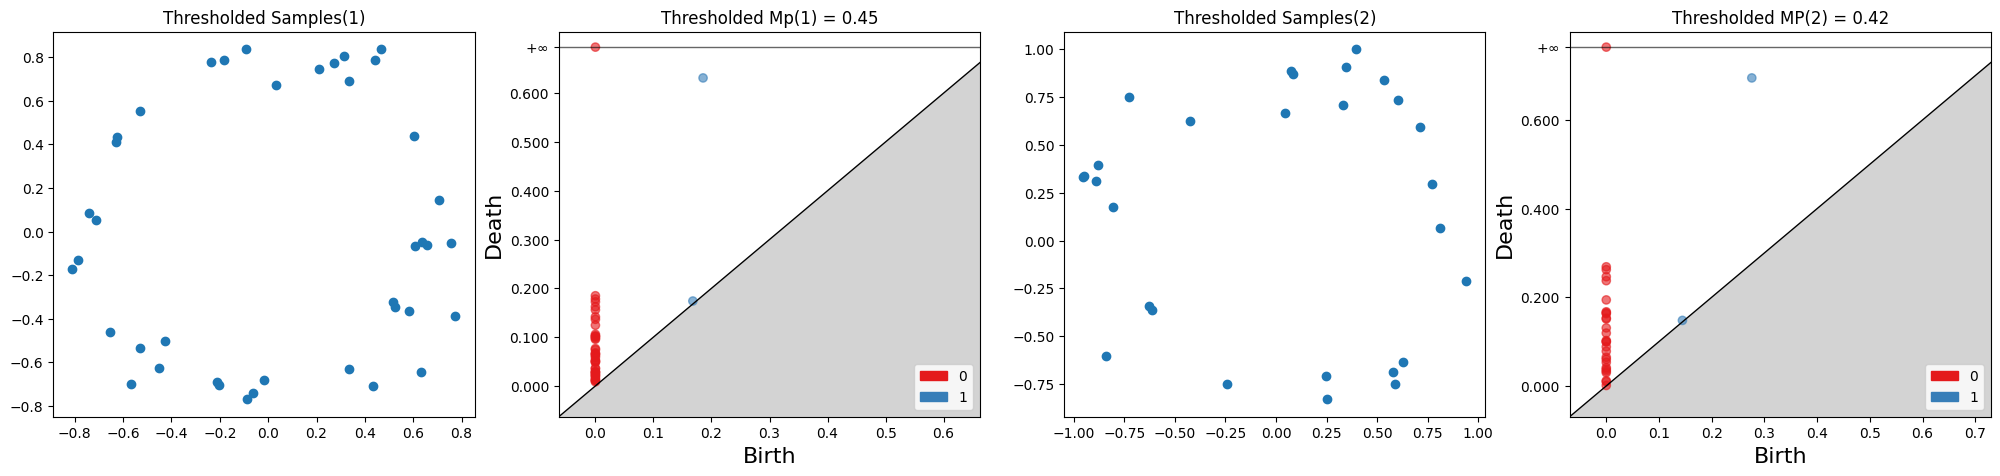

In [471]:
m = 0.001
diagram_DTM_thresh1, _, _ = dtm_diagram(sampled_thresh1, m)
diagram_DTM_thresh2, _, _ = dtm_diagram(sampled_thresh2, m)

max_pers_thresh1 = max_pers(diagram_DTM_thresh1)
max_pers_thresh2 = max_pers(diagram_DTM_thresh2)

fig, axes = plt.subplots(1, 4, figsize=(25, 5))
axes[0].scatter(x=sampled_thresh1[:, 0], y=sampled_thresh1[:, 1])
axes[0].set_title('Thresholded Samples(1)')
gudhi.plot_persistence_diagram(diagram_DTM_thresh1, axes=axes[1])
axes[1].set_title(f'Thresholded Mp(1) = {np.round(max_pers_thresh1, 2)}')

axes[2].scatter(x=sampled_thresh2[:, 0], y=sampled_thresh2[:, 1])
axes[2].set_title('Thresholded Samples(2)')
gudhi.plot_persistence_diagram(diagram_DTM_thresh2, axes=axes[3])
axes[3].set_title(f'Thresholded MP(2) = {np.round(max_pers_thresh2, 2)}')
plt.show()

In [472]:
#pd.DataFrame(sampled_thresh1).to_csv('../data/application/tde_planetspot_smooth1.csv')
#pd.DataFrame(sampled_thresh2).to_csv('../data/application/tde_matrix_planetspot_smooth2.csv')

### We can now do the dtm filtration on all the data spaces

In [15]:
# Parameters
m_grid = np.arange(0.001, 0.099 + 0.001, 0.001)
pers_grid = grid_search_dtm(planet, planetspot1, planetspot2, sampled_thresh1, sampled_thresh2, spot, m_grid, dim=1)

In [474]:
#pd.DataFrame(pers_grid).to_csv('../data/application/pers_grid1_.csv')

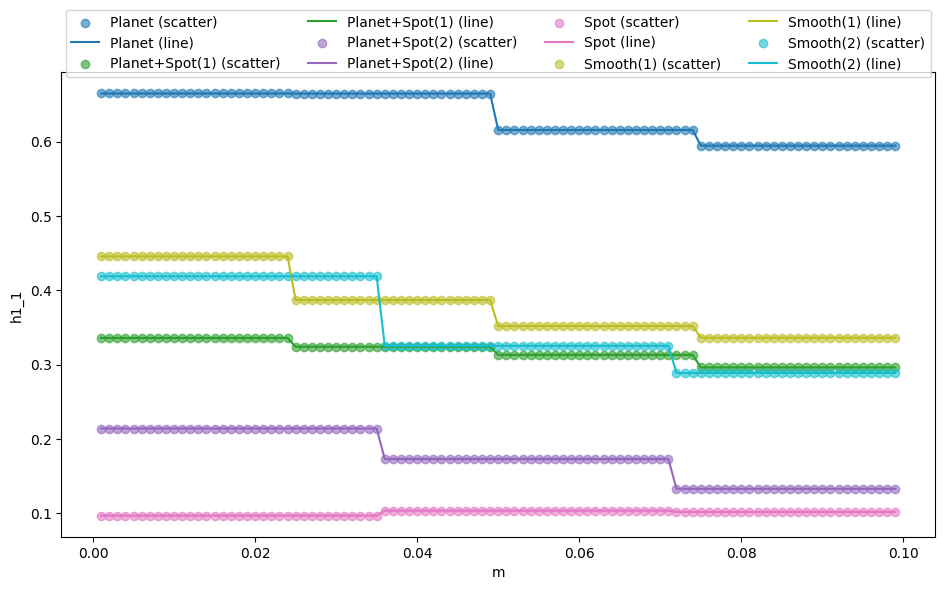

In [16]:
plt.figure(figsize=(10, 6))
# Get unique groups
groups = pers_grid['grp'].unique()
# Color map for consistency across scatter and line plots
colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))

# Create scatter and line plots for each group
for idx, group in enumerate(groups):
    mask = pers_grid['grp'] == group
    # Scatter plot
    plt.scatter(pers_grid.loc[mask, 'm'], pers_grid.loc[mask, 'h1_1'],label=f'{group} (scatter)',color=colors[idx],alpha=0.6)
    # Line plot
    plt.plot(pers_grid.loc[mask, 'm'],pers_grid.loc[mask, 'h1_1'],label=f'{group} (line)',color=colors[idx])
# Customize the plot
plt.xlabel('m'); plt.ylabel('h1_1'); plt.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4)
plt.tight_layout(); plt.show()

In [17]:
max_params = (pers_grid
             .groupby('grp')['h1_1']
             .transform('max')
             .eq(pers_grid['h1_1']))

max_params = pers_grid[max_params].copy()
print(max_params.iloc[101:151, :])

         m      h1_1             grp
121  0.021  0.335748  Planet+Spot(1)
122  0.021  0.213873  Planet+Spot(2)
124  0.021  0.445599       Smooth(1)
125  0.021  0.418777       Smooth(2)
126  0.022  0.664702          Planet
127  0.022  0.335748  Planet+Spot(1)
128  0.022  0.213873  Planet+Spot(2)
130  0.022  0.445599       Smooth(1)
131  0.022  0.418777       Smooth(2)
132  0.023  0.664702          Planet
133  0.023  0.335748  Planet+Spot(1)
134  0.023  0.213873  Planet+Spot(2)
136  0.023  0.445599       Smooth(1)
137  0.023  0.418777       Smooth(2)
138  0.024  0.664702          Planet
139  0.024  0.335748  Planet+Spot(1)
140  0.024  0.213873  Planet+Spot(2)
142  0.024  0.445599       Smooth(1)
143  0.024  0.418777       Smooth(2)
146  0.025  0.213873  Planet+Spot(2)
149  0.025  0.418777       Smooth(2)
152  0.026  0.213873  Planet+Spot(2)
155  0.026  0.418777       Smooth(2)
158  0.027  0.213873  Planet+Spot(2)
161  0.027  0.418777       Smooth(2)
164  0.028  0.213873  Planet+Spot(2)
1

In [18]:
# Compute bottleneck bootstrap
import warnings
warnings.filterwarnings("ignore")

planet_btl, planet_dgm = dtm_bootstrap(base_mat=planet, ref_mat=planet, m=0.010, dim=1, B=1000)
planetspot_btl1, planetspot_dgm1 = dtm_bootstrap(base_mat=planetspot1, ref_mat=planetspot1, m=0.01, dim=1, B=1000)
planetspot_btl2, planetspot_dgm2 = dtm_bootstrap(base_mat=planetspot2, ref_mat=planetspot2, m=0.01, dim=1, B=1000)
spot_btl, spot_dgm = dtm_bootstrap(base_mat=spot, ref_mat=spot, m=0.05, dim=1, B=1000)
smooth_btl1, smooth_dgm1 = dtm_bootstrap(base_mat=sampled_thresh1, ref_mat=planetspot1, m=0.010, dim=1, B=1000, kk=opt_kk1, th=opt_th1, is_smooth=True)
smooth_btl2, smooth_dgm2 = dtm_bootstrap(base_mat=sampled_thresh2, ref_mat=planetspot2, m=0.010, dim=1, B=1000, kk=opt_kk2, th=opt_th2, is_smooth=True)

Completed 100/1000 bootstrap iterations
Completed 200/1000 bootstrap iterations
Completed 300/1000 bootstrap iterations
Completed 400/1000 bootstrap iterations
Completed 500/1000 bootstrap iterations
Completed 600/1000 bootstrap iterations
Completed 700/1000 bootstrap iterations
Completed 800/1000 bootstrap iterations
Completed 900/1000 bootstrap iterations
Completed 1000/1000 bootstrap iterations
Completed 100/1000 bootstrap iterations
Completed 200/1000 bootstrap iterations
Completed 300/1000 bootstrap iterations
Completed 400/1000 bootstrap iterations
Completed 500/1000 bootstrap iterations
Completed 600/1000 bootstrap iterations
Completed 700/1000 bootstrap iterations
Completed 800/1000 bootstrap iterations
Completed 900/1000 bootstrap iterations
Completed 1000/1000 bootstrap iterations
Completed 100/1000 bootstrap iterations
Completed 200/1000 bootstrap iterations
Completed 300/1000 bootstrap iterations
Completed 400/1000 bootstrap iterations
Completed 500/1000 bootstrap iteration

In [19]:
btl_df = pd.DataFrame(
    {'planet': planet_btl,
     'planetspot1': planetspot_btl1,
     'planetspot2': planetspot_btl2,
     'spot': spot_btl, 
     'smooth1': smooth_btl1,
     'smooth2': smooth_btl2})
btl_df.to_csv('../data/application/bottleneck_distances.csv')
planet_dgm.to_csv('../data/application/planet_dgm.csv')
planetspot_dgm1.to_csv('../data/application/planetspot1_dgm.csv')
planetspot_dgm2.to_csv('../data/application/planetspot2_dgm.csv')
spot_dgm.to_csv('../data/application/spot_dgm.csv')
smooth_dgm1.to_csv('../data/application/smooth1_dgm.csv')
smooth_dgm2.to_csv('../data/application/smooth2_dgm.csv')